# Customer Lifetime Value Prediction

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [23]:
# This may take a couple minutes
df = pd.read_csv('data.csv', parse_dates=['InvoiceDate'])

In [24]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


## Field description
* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.
* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

Negative values of Quantity and UnitPrice indicate return orders. Will keep only positive Quantity and UnitPrice for current analysis.

In [26]:
df = df.loc[(df['Quantity']>0)&(df['UnitPrice']>0)]

#### Check null value

In [27]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

In [28]:
# Drop null value on CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [30]:
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Handle incomplete data
Period of time for the purchase records is from December 1, 2010 to December 9, 2011. The data for the last month is incomplete. Because we are planning to predict CLTV for the next 3 months and we will be aggregating data monthly, let us ignore the records for the incomplete month.

In [31]:
print('The dataset has orders made from {} to {}'.format(min(df['InvoiceDate']),
                                                         max(df['InvoiceDate'])))

The dataset has orders made from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [32]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [33]:
# Let's check the time period
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-11-30 17:37:00'))

### Calculate Sales Invoices
Create SalesAmount using Quantity\*Unitprice

In [34]:
df['SalesAmount'] = df['Quantity'] * df['UnitPrice']

In [109]:
df_orders = df.groupby(['CustomerID', 'InvoiceNo']).agg({'SalesAmount': sum, 'InvoiceDate': max})

In [110]:
df_orders.head(8)

SalesAmount         InvoiceDate
CustomerID InvoiceNo                                 
12,346.00  541431       77,183.60 2011-01-18 10:01:00
12,347.00  537626          711.79 2010-12-07 14:57:00
           542237          475.39 2011-01-26 14:30:00
           549222          636.25 2011-04-07 10:43:00
           556201          382.52 2011-06-09 13:01:00
           562032          584.91 2011-08-02 08:48:00
           573511        1,294.32 2011-10-31 12:25:00
12,348.00  539318          892.80 2010-12-16 19:09:00

In [111]:
df_orders['InvoiceDate'].max(), df_orders['InvoiceDate'].min()

(Timestamp('2011-11-30 17:37:00'), Timestamp('2010-12-01 08:26:00'))

In [99]:
def purchase_duration(x):
    return (x.max() - x.min()).days

def purchase_frequency(x):
    return (x.max() - x.min()).days / x.count()

def unique(x):
    return x.nunique
    


# Define the aggregation calculations
aggregations = {
    # work on the "duration" column
    'SalesAmount': ['min', 'max', 'sum', 'mean', 'count'],
    # Now work on the "date" column
    'InvoiceDate': ['min', 'max',  purchase_duration, purchase_frequency ],
    'InvoiceNo' : ['nunique'],
}

In [112]:
df_summary = df_orders.reset_index().groupby('CustomerID').agg(aggregations)

In [113]:
df_summary.head()

SalesAmount                                      \
                   min       max       sum      mean count   
CustomerID                                                   
12,346.00    77,183.60 77,183.60 77,183.60 77,183.60     1   
12,347.00       382.52  1,294.32  4,085.18    680.86     6   
12,348.00       227.44    892.80  1,797.24    449.31     4   
12,349.00     1,757.55  1,757.55  1,757.55  1,757.55     1   
12,350.00       334.40    334.40    334.40    334.40     1   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12,346.00  2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12,347.00  2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12,348.00  2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12,349.00  2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12,350.00  2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                              InvoiceNo  
           purchase_frequency   nunique  
CustomerID                               
12,346.00                0.00         1  
12,347.00               54.50         6  
12,348.00               70.50         4  
12,349.00                0.00         1  
12,350.00                0.00         1

In [114]:
df_summary.columns = ['_'.join(col).lower() for col in df_summary.columns]

In [115]:
df_summary.head()

,salesamount_min,salesamount_max,salesamount_sum,salesamount_mean,salesamount_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency,invoiceno_nunique
CustomerID,,,,,,,,,,
"12,346.00","77,183.60","77,183.60","77,183.60","77,183.60",1,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.00,1
"12,347.00",382.52,"1,294.32","4,085.18",680.86,6,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.50,6
"12,348.00",227.44,892.80,"1,797.24",449.31,4,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.50,4
"12,349.00","1,757.55","1,757.55","1,757.55","1,757.55",1,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.00,1
"12,350.00",334.40,334.40,334.40,334.40,1,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.00,1


In [116]:
# Repeat customer
df_summary = df_summary.loc[df_summary['invoicedate_purchase_duration'] > 0]

In [117]:
df_summary.shape

(2692, 10)

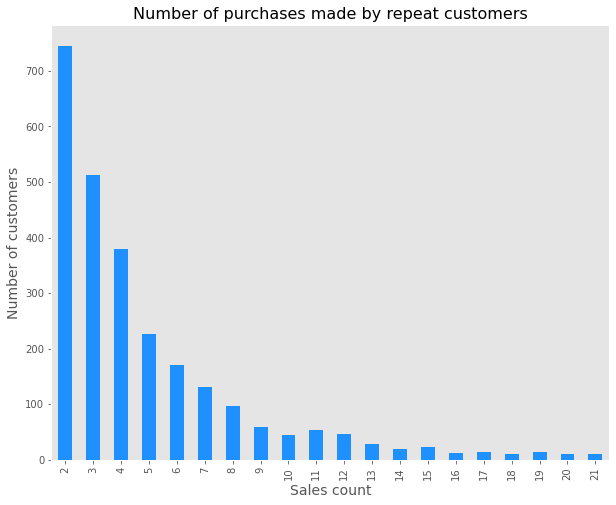

In [118]:
# Let's look at the number of purchases
ax = df_summary.groupby('invoiceno_nunique').count()['salesamount_sum'][:20].plot(
        kind='bar', 
        color='dodgerblue', 
        figsize=(10,8), 
        grid=False)
plt.xlabel('Sales count', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Number of purchases made by repeat customers', fontsize=16);

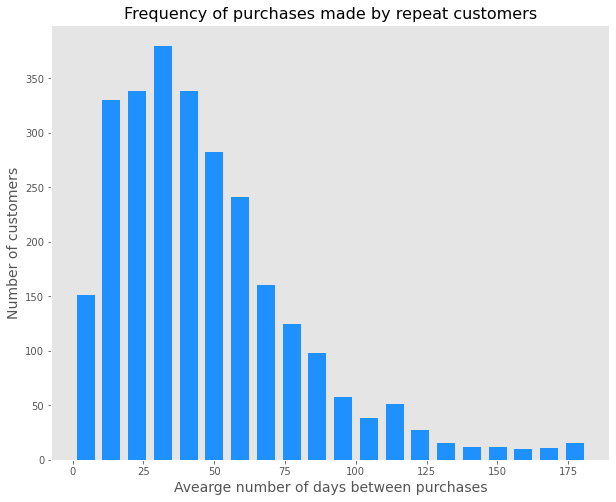

In [119]:
ax = df_summary['invoicedate_purchase_frequency'].hist(
        bins=20,
        color='dodgerblue',
        rwidth=0.7,
        figsize=(10,8),
        grid=False)
plt.xlabel('Avearge number of days between purchases', fontsize=14)
plt.ylabel('Number of customers', fontsize=14)
plt.title('Frequency of purchases made by repeat customers', fontsize=16);

In [295]:
clv_freq = '3M'

In [296]:
df_data = df_orders.reset_index().groupby([
            'CustomerID',
            pd.Grouper(key='InvoiceDate', freq=clv_freq)
            ]).agg({'SalesAmount': [sum, 'mean', 'count'],})

In [297]:
df_data.columns = ['_'.join(col).lower() for col in df_data.columns]

In [298]:
df_data = df_data.reset_index()

In [431]:
df_data = df_data.loc[df_data['salesamount_sum'] > 0]

In [432]:
df_data.head()

,CustomerID,InvoiceDate,salesamount_sum,salesamount_mean,salesamount_count,M
0,"12,346.00",2011-03-31,"77,183.60","77,183.60",1,M_4
1,"12,347.00",2010-12-31,711.79,711.79,1,M_5
2,"12,347.00",2011-03-31,475.39,475.39,1,M_4
3,"12,347.00",2011-06-30,"1,018.77",509.38,2,M_3
4,"12,347.00",2011-09-30,584.91,584.91,1,M_2


In [433]:
df_data.shape

(9219, 6)

In [434]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9219 entries, 0 to 9218
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerID         9219 non-null   float64       
 1   InvoiceDate        9219 non-null   datetime64[ns]
 2   salesamount_sum    9219 non-null   float64       
 3   salesamount_mean   9219 non-null   float64       
 4   salesamount_count  9219 non-null   int64         
 5   M                  9219 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 504.2+ KB


In [435]:
map_date_month = {str(x)[:10]: 'M_%s' % (i+1) for i, x in enumerate(
                    sorted(df_data.reset_index()['InvoiceDate'].unique(), reverse=True))}

In [436]:
map_date_month

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

In [437]:
df_data['M'] = df_data['InvoiceDate'].apply(lambda x: map_date_month[str(x)[:10]])

In [438]:
df_data.head()

,CustomerID,InvoiceDate,salesamount_sum,salesamount_mean,salesamount_count,M
0,"12,346.00",2011-03-31,"77,183.60","77,183.60",1,M_4
1,"12,347.00",2010-12-31,711.79,711.79,1,M_5
2,"12,347.00",2011-03-31,475.39,475.39,1,M_4
3,"12,347.00",2011-06-30,"1,018.77",509.38,2,M_3
4,"12,347.00",2011-09-30,584.91,584.91,1,M_2


In [439]:
# Number of purchases made in each chunk
df_data['M'].value_counts()

M_1    2406
M_2    2161
M_3    1991
M_4    1776
M_5     885
Name: M, dtype: int64

In [440]:
df_features = pd.pivot_table(
                df_data.loc[df_data['M'] != 'M_1'], 
                values=['salesamount_sum', 'salesamount_mean', 'salesamount_count'], 
                columns='M', 
                index='CustomerID')

In [441]:
df_features.reset_index()

CustomerID salesamount_count                salesamount_mean         \
M                             M_2  M_3  M_4  M_5              M_2    M_3   
0     12,346.00               NaN  NaN 1.00  NaN              NaN    NaN   
1     12,347.00              1.00 2.00 1.00 1.00           584.91 509.38   
2     12,348.00              1.00 1.00 1.00 1.00           310.00 367.00   
3     12,350.00               NaN  NaN 1.00  NaN              NaN    NaN   
4     12,352.00              2.00  NaN 5.00  NaN           316.25    NaN   
...         ...               ...  ...  ...  ...              ...    ...   
3611  18,280.00               NaN  NaN 1.00  NaN              NaN    NaN   
3612  18,281.00               NaN 1.00  NaN  NaN              NaN  80.82   
3613  18,282.00              1.00  NaN  NaN  NaN           100.21    NaN   
3614  18,283.00              3.00 4.00 3.00  NaN            92.70 131.17   
3615  18,287.00               NaN 1.00  NaN  NaN              NaN 765.28   

                      salesamount_sum                            
M          M_4    M_5             M_2      M_3       M_4    M_5  
0    77,183.60    NaN             NaN      NaN 77,183.60    NaN  
1       475.39 711.79          584.91 1,018.77    475.39 711.79  
2       227.44 892.80          310.00   367.00    227.44 892.80  
3       334.40    NaN             NaN      NaN    334.40    NaN  
4       312.36    NaN          632.50      NaN  1,561.81    NaN  
...        ...    ...             ...      ...       ...    ...  
3611    180.60    NaN             NaN      NaN    180.60    NaN  
3612       NaN    NaN             NaN    80.82       NaN    NaN  
3613       NaN    NaN          100.21      NaN       NaN    NaN  
3614    105.97    NaN          278.09   524.68    317.90    NaN  
3615       NaN    NaN             NaN   765.28       NaN    NaN  

[3616 rows x 13 columns]

In [442]:
df_features.columns = ['_'.join(col) for col in df_features.columns]

In [443]:
df_features.head()

,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5
CustomerID,,,,,,,,,,,,
"12,346.00",NaN,NaN,1.00,NaN,NaN,NaN,"77,183.60",NaN,NaN,NaN,"77,183.60",NaN
"12,347.00",1.00,2.00,1.00,1.00,584.91,509.38,475.39,711.79,584.91,"1,018.77",475.39,711.79
"12,348.00",1.00,1.00,1.00,1.00,310.00,367.00,227.44,892.80,310.00,367.00,227.44,892.80
"12,350.00",NaN,NaN,1.00,NaN,NaN,NaN,334.40,NaN,NaN,NaN,334.40,NaN
"12,352.00",2.00,NaN,5.00,NaN,316.25,NaN,312.36,NaN,632.50,NaN,"1,561.81",NaN


In [444]:
df_features.reset_index(level=0, inplace=True)

In [445]:
df_features.head()

,CustomerID,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5
0,"12,346.00",NaN,NaN,1.00,NaN,NaN,NaN,"77,183.60",NaN,NaN,NaN,"77,183.60",NaN
1,"12,347.00",1.00,2.00,1.00,1.00,584.91,509.38,475.39,711.79,584.91,"1,018.77",475.39,711.79
2,"12,348.00",1.00,1.00,1.00,1.00,310.00,367.00,227.44,892.80,310.00,367.00,227.44,892.80
3,"12,350.00",NaN,NaN,1.00,NaN,NaN,NaN,334.40,NaN,NaN,NaN,334.40,NaN
4,"12,352.00",2.00,NaN,5.00,NaN,316.25,NaN,312.36,NaN,632.50,NaN,"1,561.81",NaN


In [446]:
df_features.fillna(0, inplace=True)

In [447]:
# Let's check the Null values
df_features.isnull().sum().sum()

0

In [448]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             3616 non-null   float64
 1   salesamount_count_M_2  3616 non-null   float64
 2   salesamount_count_M_3  3616 non-null   float64
 3   salesamount_count_M_4  3616 non-null   float64
 4   salesamount_count_M_5  3616 non-null   float64
 5   salesamount_mean_M_2   3616 non-null   float64
 6   salesamount_mean_M_3   3616 non-null   float64
 7   salesamount_mean_M_4   3616 non-null   float64
 8   salesamount_mean_M_5   3616 non-null   float64
 9   salesamount_sum_M_2    3616 non-null   float64
 10  salesamount_sum_M_3    3616 non-null   float64
 11  salesamount_sum_M_4    3616 non-null   float64
 12  salesamount_sum_M_5    3616 non-null   float64
dtypes: float64(13)
memory usage: 367.4 KB


In [449]:
df_features.head()

,CustomerID,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5
0,"12,346.00",0.00,0.00,1.00,0.00,0.00,0.00,"77,183.60",0.00,0.00,0.00,"77,183.60",0.00
1,"12,347.00",1.00,2.00,1.00,1.00,584.91,509.38,475.39,711.79,584.91,"1,018.77",475.39,711.79
2,"12,348.00",1.00,1.00,1.00,1.00,310.00,367.00,227.44,892.80,310.00,367.00,227.44,892.80
3,"12,350.00",0.00,0.00,1.00,0.00,0.00,0.00,334.40,0.00,0.00,0.00,334.40,0.00
4,"12,352.00",2.00,0.00,5.00,0.00,316.25,0.00,312.36,0.00,632.50,0.00,"1,561.81",0.00


In [450]:
df_target = df_data.loc[df_data['M'] == 'M_1', ['CustomerID', 'salesamount_sum']]

In [451]:
df_target.columns = ['CustomerID', 'CLV_'+clv_freq]

In [452]:
df_target.shape

(2406, 2)

In [453]:
df_target.head()

,CustomerID,CLV_3M
5,"12,347.00","1,294.32"
10,"12,349.00","1,757.55"
14,"12,352.00",311.73
20,"12,356.00",58.35
21,"12,357.00","6,207.67"


In [493]:
df_sample_set = df_features.merge(
                df_target, 
                left_on='CustomerID', 
                right_on='CustomerID',
                how='left')

In [494]:
df_sample_set.fillna(0, inplace=True)

In [495]:
df_sample_set.head()

,CustomerID,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5,CLV_3M
0,"12,346.00",0.00,0.00,1.00,0.00,0.00,0.00,"77,183.60",0.00,0.00,0.00,"77,183.60",0.00,0.00
1,"12,347.00",1.00,2.00,1.00,1.00,584.91,509.38,475.39,711.79,584.91,"1,018.77",475.39,711.79,"1,294.32"
2,"12,348.00",1.00,1.00,1.00,1.00,310.00,367.00,227.44,892.80,310.00,367.00,227.44,892.80,0.00
3,"12,350.00",0.00,0.00,1.00,0.00,0.00,0.00,334.40,0.00,0.00,0.00,334.40,0.00,0.00
4,"12,352.00",2.00,0.00,5.00,0.00,316.25,0.00,312.36,0.00,632.50,0.00,"1,561.81",0.00,311.73


In [457]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [458]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in df_sample_set.columns if x not in ['CustomerID', target_var]]

In [459]:
all_features

['salesamount_count_M_2',
 'salesamount_count_M_3',
 'salesamount_count_M_4',
 'salesamount_count_M_5',
 'salesamount_mean_M_2',
 'salesamount_mean_M_3',
 'salesamount_mean_M_4',
 'salesamount_mean_M_5',
 'salesamount_sum_M_2',
 'salesamount_sum_M_3',
 'salesamount_sum_M_4',
 'salesamount_sum_M_5']

In [460]:
df_sample_set

,CustomerID,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5,CLV_3M
0,"12,346.00",0.00,0.00,1.00,0.00,0.00,0.00,"77,183.60",0.00,0.00,0.00,"77,183.60",0.00,0.00
1,"12,347.00",1.00,2.00,1.00,1.00,584.91,509.38,475.39,711.79,584.91,"1,018.77",475.39,711.79,"1,294.32"
2,"12,348.00",1.00,1.00,1.00,1.00,310.00,367.00,227.44,892.80,310.00,367.00,227.44,892.80,0.00
3,"12,350.00",0.00,0.00,1.00,0.00,0.00,0.00,334.40,0.00,0.00,0.00,334.40,0.00,0.00
4,"12,352.00",2.00,0.00,5.00,0.00,316.25,0.00,312.36,0.00,632.50,0.00,"1,561.81",0.00,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3611,"18,280.00",0.00,0.00,1.00,0.00,0.00,0.00,180.60,0.00,0.00,0.00,180.60,0.00,0.00
3612,"18,281.00",0.00,1.00,0.00,0.00,0.00,80.82,0.00,0.00,0.00,80.82,0.00,0.00,0.00
3613,"18,282.00",1.00,0.00,0.00,0.00,100.21,0.00,0.00,0.00,100.21,0.00,0.00,0.00,0.00
3614,"18,283.00",3.00,4.00,3.00,0.00,92.70,131.17,105.97,0.00,278.09,524.68,317.90,0.00,766.21


In [461]:
X_train, X_test, y_train, y_test = train_test_split(
                                    df_sample_set[all_features], 
                                    df_sample_set[target_var], 
                                    random_state=2,
                                    test_size=0.35)

In [462]:
lin_reg = LinearRegression(n_jobs=1)

In [463]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [464]:
lin_reg.intercept_

-17.526580313481986

In [465]:
coef = pd.DataFrame(list(zip(all_features, lin_reg.coef_)))
coef.columns = ['feature', 'coef']

In [466]:
coef.sort_values('coef', ascending=False)

,feature,coef
0,salesamount_count_M_2,128.56
2,salesamount_count_M_4,18.09
11,salesamount_sum_M_5,0.91
9,salesamount_sum_M_3,0.38
8,salesamount_sum_M_2,0.25
4,salesamount_mean_M_2,0.21
6,salesamount_mean_M_4,0.09
5,salesamount_mean_M_3,-0.06
10,salesamount_sum_M_4,-0.08
7,salesamount_mean_M_5,-0.58


In [467]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [468]:
train_preds =  lin_reg.predict(X_train)
test_preds = lin_reg.predict(X_test)

In [469]:
print('R-Squared for Train set: %0.2f' % r2_score(y_true=y_train, y_pred=train_preds))
print('R-Squared for Test set: %0.2f' % r2_score(y_true=y_test, y_pred=test_preds))

R-Squared for Train set: 0.71
R-Squared for Test set: 0.71


R-Squared is the same for the train and test sets. Therefore, we do not have any overfitting or underfitting of the model.

In [470]:
print('MAE for Train set: %0.2f' % mean_absolute_error(y_true=y_train, y_pred=train_preds))
print('MAE for Test set: %0.2f' % mean_absolute_error(y_true=y_test, y_pred=test_preds))

MAE for Train set: 414.23
MAE for Test set: 399.96


In [471]:

print('MedAE for Train set: %0.2f' % median_absolute_error(y_true=y_train, y_pred=train_preds))
print('MedAE for Test set: %0.2f' % median_absolute_error(y_true=y_test, y_pred=test_preds))

MedAE for Train set: 202.41
MedAE for Test set: 205.20


MedAE has a small difference between test and train sets.

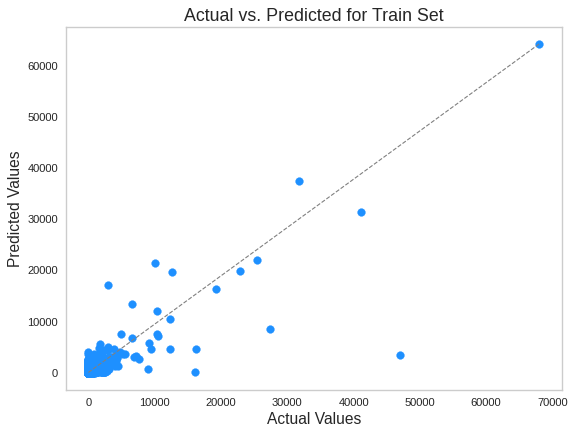

In [472]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(y_train, train_preds, color='dodgerblue')
plt.plot([0, max(y_train)], [0, max(train_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted for Train Set', fontsize=16)
plt.grid()

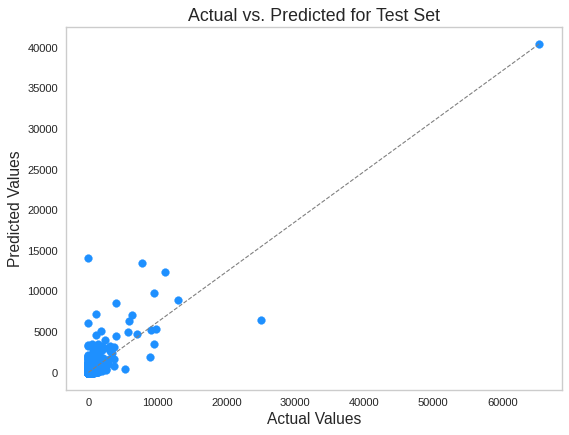

In [473]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(y_test, test_preds, color='dodgerblue')
plt.plot([0, max(y_test)], [0, max(test_preds)], color='gray', lw=1, linestyle='--')

plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Actual vs. Predicted for Test Set', fontsize=16)
plt.grid()

### Summary
* Based on the data analysis, we found that the repeat customers tend to make about 12 purchases or less within a year and the majority of repeat customers tend to make a purchase every 12 to 50 days
* We predicted 3-month CLTV for customers of the online retail using linear regression
* R-squared value for the test set is 0.71, which is not great but it is a good benchmark to try other regression models such as Epsilon-Support Vector Regression and Random Forest Regressor
* By knowing CLTV, we can develop positive ROI strategies and make decisions about how much money to invest in acquiring new customers and retaining existing ones.

## PyCaret

In [496]:
df_sample_set.shape

(3616, 14)

In [497]:
df_sample_set = df_sample_set.loc[df_sample_set['CLV_'+clv_freq] > 0]

In [498]:
df_sample_set.shape

(3616, 14)

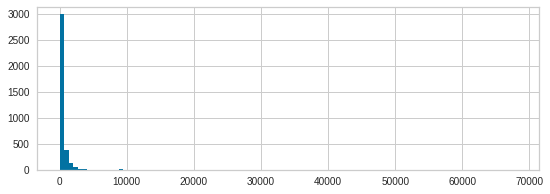

In [499]:
df_sample_set['CLV_'+clv_freq].hist(bins=100, figsize=(9,3))

plt.show()

In [475]:
data = df_sample_set.sample(frac=0.9, random_state=786).reset_index(drop=True)
data_unseen = df_sample_set.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (3254, 14)
Unseen Data For Predictions: (362, 14)


In [503]:
# init setup
from pycaret.regression import *
s = setup(data = data, 
          target = 'CLV_'+clv_freq, 
          train_size=0.8, 
          session_id=10,
          normalize=True, 
          ignore_features = ['CustomerID'])

,Description,Value
0,session_id,10
1,Target,CLV_3M
2,Original Data,"(3254, 14)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(2603, 12)"


In [504]:
# compare all models
compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,435.1620,2192284.3302,1344.3812,0.2636,3.7647,0.7106,0.0060
en,Elastic Net,448.5198,2429692.3625,1362.5895,0.4260,3.6999,0.8332,0.0070
par,Passive Aggressive Regressor,396.4635,2430894.9492,1405.6234,0.3151,3.1210,0.7329,0.0080
huber,Huber Regressor,408.1868,2527282.6029,1424.0703,0.3128,3.4352,0.6629,0.0140
llar,Lasso Least Angle Regression,431.8559,2667618.8044,1444.7338,0.3077,3.5954,0.6827,0.0070
knn,K Neighbors Regressor,438.8358,3270268.0281,1500.1282,0.4151,3.7142,0.7356,0.0120
rf,Random Forest Regressor,437.0392,2891530.5187,1500.5352,0.2107,3.5758,0.7212,0.2490
et,Extra Trees Regressor,451.4422,3029796.6843,1524.2814,0.2365,3.5717,0.8063,0.1510
lightgbm,Light Gradient Boosting Machine,469.9079,3222593.7620,1576.5859,0.0908,3.7473,0.6986,0.0290
br,Bayesian Ridge,448.1545,3399402.1243,1601.6181,0.1477,3.6059,0.7296,0.0070


OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)

You can focus on RMSE for now, which stands for Root Mean Squared Error. RMSE is a widely used metric for regression, and it is defined as the square root of the averaged squared difference between the actual value and the one predicted by the model:

**The lower the RMSE value, the more accurate our model is**. In this case, the best model is the Gradient Boosting Regressor model, with an RMSE value of 1344

In [508]:
best_model = create_model('omp', cross_validation=True, fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,576.9350,6689164.6362,2586.3419,0.4477,3.6345,0.6930
1,469.9827,1183937.5972,1088.0890,0.3205,3.6601,0.6633
2,357.6512,566444.7114,752.6252,0.9178,4.0343,0.6996
3,534.7727,3374198.8770,1836.8993,0.8422,4.0423,0.6589
4,472.5899,2402181.7663,1549.8973,0.3769,3.8136,0.9185
5,394.0701,1201281.6466,1096.0299,-0.1102,3.6178,0.6845
6,394.8081,1470774.1264,1212.7548,0.4550,3.7195,0.6159
7,301.8649,260312.1589,510.2080,0.2911,3.8606,0.6720
8,499.8645,4191315.7526,2047.2703,-1.2488,3.6179,0.7410
9,349.0811,583232.0293,763.6963,0.3434,3.6466,0.7598


In [506]:
# print best_model parameters
print(best_model)

OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None)


In [510]:
# tune best model
tuned_best_model = tune_model(estimator=best_model, optimize='RMSE', fold=10, n_iter=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,578.7467,7589704.4107,2754.9418,0.3733,3.4129,0.6828
1,479.2825,1839108.6080,1356.1374,-0.0556,3.7227,0.5980
2,353.1869,711502.8960,843.5063,0.8967,3.9646,0.5827
3,454.4143,1792984.9691,1339.0239,0.9162,3.8711,0.6403
4,427.0212,2013937.2367,1419.1326,0.4776,3.6105,1.1068
5,397.2291,1270180.8017,1127.0230,-0.1739,3.5446,0.6410
6,377.6807,1634937.7088,1278.6468,0.3942,3.5913,0.5677
7,289.9109,246578.2649,496.5665,0.3285,3.6828,0.6166
8,445.0378,2709959.8579,1646.1956,-0.4540,3.5537,0.6824
9,386.1588,798653.5804,893.6742,0.1009,3.5003,0.7568


RMSE Reduce from 1344.3812 to 1315.4848

In [416]:
plot_model(tuned_best_model, plot="parameter")

,Parameters
alpha,1.0
copy_X,True
eps,0.007
fit_intercept,True
fit_path,True
jitter,None
max_iter,500
normalize,True
positive,False
precompute,auto


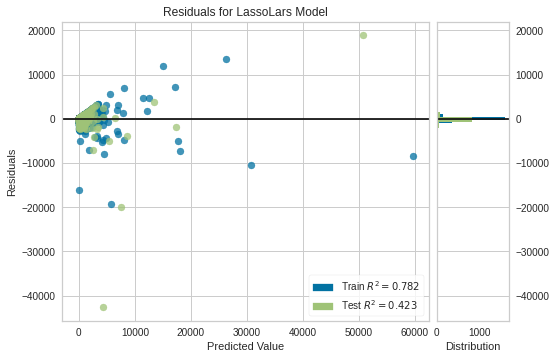

In [417]:
plot_model(tuned_best_model)

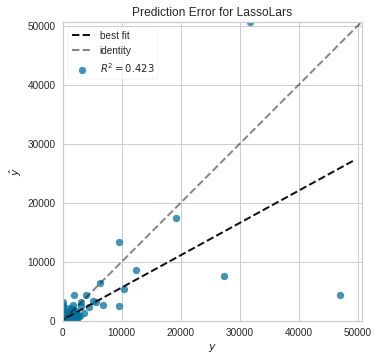

In [418]:
plot_model(tuned_best_model, plot = 'error')

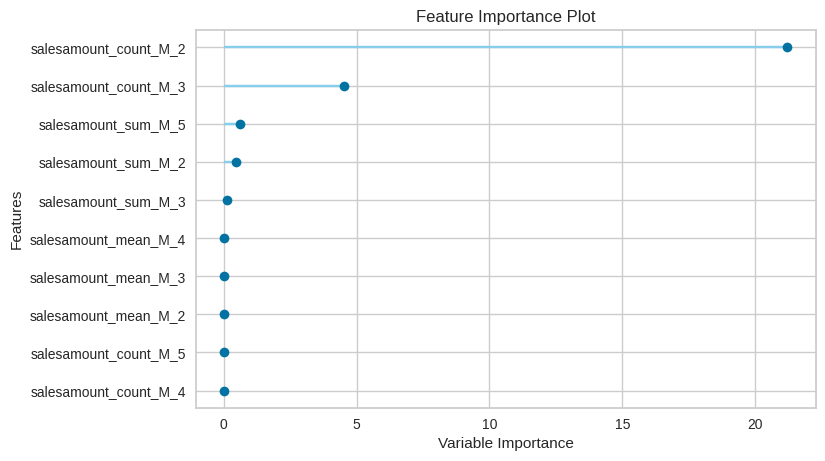

In [419]:
# Feature Importance Plot
plot_model(tuned_best_model, plot = 'feature')

In [420]:
predict_model(tuned_best_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,397.7544,2985924.1844,1727.9827,0.4232,3.4947,0.5893


In [421]:
final_model = finalize_model(tuned_best_model)

In [422]:
#Final Light Gradient Boosting Machine parameters for deployment
print(final_model)

LassoLars(alpha=1.0, copy_X=True, eps=0.007, fit_intercept=True, fit_path=True,
          jitter=None, max_iter=500, normalize=True, positive=False,
          precompute='auto', random_state=4758, verbose=False)


In [423]:
predict_model(final_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Least Angle Regression,394.1029,2750316.2542,1658.4077,0.4687,3.5193,0.6288


In [424]:
unseen_predictions = predict_model(final_model, data=data_unseen)
unseen_predictions.head()

,CustomerID,salesamount_count_M_2,salesamount_count_M_3,salesamount_count_M_4,salesamount_count_M_5,salesamount_mean_M_2,salesamount_mean_M_3,salesamount_mean_M_4,salesamount_mean_M_5,salesamount_sum_M_2,salesamount_sum_M_3,salesamount_sum_M_4,salesamount_sum_M_5,CLV_3M,Label
0,"17,685.00",1.00,0.00,3.00,2.00,"1,286.41",0.00,349.90,231.51,"1,286.41",0.00,"1,049.70",463.02,392.40,882.78
1,"17,686.00",2.00,3.00,1.00,0.00,"1,036.67",481.38,"1,592.61",0.00,"2,073.34","1,444.14","1,592.61",0.00,0.00,"1,160.41"
2,"17,690.00",1.00,4.00,2.00,4.00,462.75,346.47,495.07,171.98,462.75,"1,385.88",990.15,687.90,"1,231.27","1,014.63"
3,"17,691.00",0.00,0.00,0.00,2.00,0.00,0.00,0.00,145.20,0.00,0.00,0.00,290.40,0.00,197.76
4,"17,692.00",1.00,1.00,1.00,1.00,117.48,169.50,110.70,343.26,117.48,169.50,110.70,343.26,0.00,389.30


The Label column is added onto the data_unseen set. Label is the predicted value using the final_model.

The new model with pycaret is get MAE = 394

In [513]:
xgb = create_model('lightgbm', cross_validation=True, verbose=False)

interpret_model(xgb, plot='reason', observation=32)